In [1]:
import pandas as pd
import numpy as np
import re
import glob
import os
import random
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
from itertools import product

# Group A: Machine Learning for Stock Options Pricing

## Project Summary
This project applies machine learning methods to predict SPY ETF maximum prices and estimate call option fair values. Unlike traditional models (e.g., Black-Scholes) that focus on expiration-day prices, we adopt a maximum likelihood framework—predicting the highest price the underlying is likely to reach before expiration, which better reflects actual trading behavior.

## Methods Used
- Gradient Boosting Machine (GBM)
- Support Vector Regression (SVR)
- Multi-Layer Perceptron (MLP)
- Long Short-Term Memory (LSTM) Neural Network
- Black-Scholes Model (for comparison)

## Techniques Beyond Class Coverage
- LSTM networks for time-series prediction
- Maximum likelihood framework for options pricing (novel application)
- Grid search for tuning the hyperparameter in lightGBM

## Data Sources
- **Options Data**: [OptionMetrics](https://optionmetrics.com/) (via Rutgers Library)
- **Interest Rates & Dividend Yields**: [S&P Capital IQ](https://www.capitaliq.com/)

## Dataset We Actually Used
- **Random Train/Test Splita**: https://drive.google.com/file/d/17fOKO-6-wYDptGWk4hFD93eBXUBlkBmu/view?usp=drive_link
- **Chronological Train/Test Splita** https://drive.google.com/file/d/1LY7NLy-R9YAONRPHc7kOmGok5M8d8qUb/view?usp=drive_link

In [119]:
data = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/data_payoff_split.csv')
pd.set_option('display.max_columns', None)
data.tail()

,SPY Price,best_bid,best_offer,cp_flag,date,days_to_exp,delta,exdate,expiry_indicator,gamma,impl_volatility,last_date,moneyness,open_interest,optionid,symbol,theta,vega,volume,strike_price,option_price_mid,Dates,IsTradingDay,Trading Index,Dates_parsed,SPDR S&P 500 ETF (ARCA:SPY) - Share Pricing,SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield,Log Returns,Standard deviation (annual),SD of SD,Risk-free rate (annual),Lookback for Calculating Volatility,Max - Forward 1,Max - Forward 2,Max - Forward 3,Max - Forward 4,Max - Forward 5,Max - Forward 6,Max - Forward 7,Max - Forward 8,Max - Forward 9,Max - Forward 10,Max - Forward 11,Max - Forward 12,Max - Forward 13,Max - Forward 14,Max - Forward 15,Max - Forward 16,Max - Forward 17,Max - Forward 18,Max - Forward 19,Max - Forward 20,Max - Forward 21,Max - Forward 22,Max - Forward 23,Max - Forward 24,Max - Forward 25,Max - Forward 26,Max - Forward 27,Max - Forward 28,Max - Forward 29,Max - Forward 30,Max - Forward 31,Max - Forward 32,Max - Forward 33,Max - Forward 34,Max - Forward 35,Max - Forward 36,Max - Forward 37,Max - Forward 38,Max - Forward 39,Max - Forward 40,Max - Forward 41,Max - Forward 42,Prediction 42,Loss,Max - Back 1,Min - Back 1,Delta Back 1,Max - Back 2,Min - Back 2,Delta Back 2,Max - Back 3,Min - Back 3,Delta Back 3,Max - Back 4,Min - Back 4,Delta Back 4,Max - Back 5,Min - Back 5,Delta Back 5,Max - Back 6,Min - Back 6,Delta Back 6,Max - Back 7,Min - Back 7,Delta Back 7,Max - Back 8,Min - Back 8,Delta Back 8,Max - Back 9,Min - Back 9,Delta Back 9,Max - Back 10,Min - Back 10,Delta Back 10,Max - Back 11,Min - Back 11,Delta Back 11,Max - Back 12,Min - Back 12,Delta Back 12,Max - Back 13,Min - Back 13,Delta Back 13,Max - Back 14,Min - Back 14,Delta Back 14,Max - Back 15,Min - Back 15,Delta Back 15,Max - Back 16,Min - Back 16,Delta Back 16,Max - Back 17,Min - Back 17,Delta Back 17,Max - Back 18,Min - Back 18,Delta Back 18,Max - Back 19,Min - Back 19,Delta Back 19,Max - Back 20,Min - Back 20,Delta Back 20,Max - Back 21,Min - Back 21,Delta Back 21,Max - Back 22,Min - Back 22,Delta Back 22,Max - Back 23,Min - Back 23,Delta Back 23,Max - Back 24,Min - Back 24,Delta Back 24,Max - Back 25,Min - Back 25,Delta Back 25,Max - Back 26,Min - Back 26,Delta Back 26,Max - Back 27,Min - Back 27,Delta Back 27,Max - Back 28,Min - Back 28,Delta Back 28,Max - Back 29,Min - Back 29,Delta Back 29,Max - Back 30,Min - Back 30,Delta Back 30,Max - Back 31,Min - Back 31,Delta Back 31,Max - Back 32,Min - Back 32,Delta Back 32,Max - Back 33,Min - Back 33,Delta Back 33,Max - Back 34,Min - Back 34,Delta Back 34,Max - Back 35,Min - Back 35,Delta Back 35,Max - Back 36,Min - Back 36,Delta Back 36,Max - Back 37,Min - Back 37,Delta Back 37,Max - Back 38,Min - Back 38,Delta Back 38,Max - Back 39,Min - Back 39,Delta Back 39,Max - Back 40,Min - Back 40,Delta Back 40,Max - Back 41,Min - Back 41,Delta Back 41,Max - Back 42,Min - Back 42,Delta Back 42,Dates_clean,target,Dividend Yield Clean,Dividend_Yield_Clean,strike_price_adj,T,d1,d2,N_d1,N_d2,BS_call,pred_MLP,pred_LSTM,pred_SVR,pred_GBM,MLP predicted max vs strike,LSTM predicted max vs strike,SVR predicted max vs strike,GBM predicted max vs strike
145575,380.82001,5.99,6.01,C,2023-01-03,6,0.617623,2023-01-09,w,0.035303,0.221257,2023-01-03,1.007460,891,151714097,SPY 230109C378000,-134.4925,18.626780,2549,378000,6.000,Jan-03-2023,True,2332.0,2023-01-03,380.82,1.62%,-0.004219,0.260931,0.022809,0.044,NaN,383.76,383.76,388.08,388.08,388.08,388.08,390.58,395.52,396.96,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,400.63,400.63,400.63,404.75,405.68,405.68,405.68,405.68,406.48,410.8,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,412.182599,21.136099,382.43,380.82,1.004228,382.43,380.82,1.004228,382.43,380.82,1.004228,382.43,380.82,1.004228,383.44,380.82,1.00688,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,386.23,376.66,1.025

# Data Processing

1. Based on the columns in 'data_col_df', filtered the useful colomns in 'data_filtered_df'.
2. Append all the columns of 'data_added_df' to 'data_filtered_df'.
3. We only use the data of call option
4. We choose the strike price is within 1% of the SPY price.
5. We select the expiration date is within 6 weeks of the current date.


In [3]:
data_filtered_df = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data.csv')
pd.set_option('display.max_columns', None)
data_filtered_df.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,days_to_exp,TICKER,PRC,moneyness
0,109820,2018-01-02,SPY 180103C235000,1,2018-01-03,2017-12-28,C,235000,33.59,33.81,0,187,NaN,NaN,NaN,NaN,NaN,118211046,1,0,100,0,NaN,w,NaN,NaN,78462F10,SPY,NaN,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1,SPY,268.76999,1.143702
1,109820,2018-01-02,SPY 180103C240000,1,2018-01-03,2018-01-02,C,240000,28.59,28.76,1,88,NaN,NaN,NaN,NaN,NaN,118211047,1,0,100,0,NaN,w,NaN,NaN,78462F10,SPY,NaN,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1,SPY,268.76999,1.119875
2,109820,2018-01-02,SPY 180103C242500,1,2018-01-03,2017-12-27,C,242500,26.09,26.32,0,2,NaN,NaN,NaN,NaN,NaN,118462481,1,0,100,0,NaN,w,NaN,NaN,78462F10,SPY,NaN,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1,SPY,268.76999,1.108330
3,109820,2018-01-02,SPY 180103C245000,1,2018-01-03,2018-01-02,C,245000,23.59,23.81,12,58,NaN,NaN,NaN,NaN,NaN,118211048,1,0,100,0,NaN,w,NaN,NaN,78462F10,SPY,NaN,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1,SPY,268.76999,1.097020
4,109820,2018-01-02,SPY 180103C247500,1,2018-01-03,NaN,C,247500,21.08,21.32,0,0,NaN,NaN,NaN,NaN,NaN,118462482,1,0,100,0,NaN,w,NaN,NaN,78462F10,SPY,NaN,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1,SPY,268.76999,1.085939


In [4]:
data_col_df = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data amended.csv')
data_col_df.head()

,date,symbol,exdate,last_date,cp_flag,Strike Price,best_bid,best_offer,Option Price (Mid),volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,expiry_indicator,days_to_exp,SPY Price,moneyness
0,1/2/18,SPY 180103C235000,1/3/18,12/28/17,C,235.0,33.59,33.81,33.700,0,187,NaN,NaN,NaN,NaN,NaN,118211046,w,1,268.76999,1.143702
1,1/2/18,SPY 180103C240000,1/3/18,1/2/18,C,240.0,28.59,28.76,28.675,1,88,NaN,NaN,NaN,NaN,NaN,118211047,w,1,268.76999,1.119875
2,1/2/18,SPY 180103C242500,1/3/18,12/27/17,C,242.5,26.09,26.32,26.205,0,2,NaN,NaN,NaN,NaN,NaN,118462481,w,1,268.76999,1.108330
3,1/2/18,SPY 180103C245000,1/3/18,1/2/18,C,245.0,23.59,23.81,23.700,12,58,NaN,NaN,NaN,NaN,NaN,118211048,w,1,268.76999,1.097020
4,1/2/18,SPY 180103C247500,1/3/18,NaN,C,247.5,21.08,21.32,21.200,0,0,NaN,NaN,NaN,NaN,NaN,118462482,w,1,268.76999,1.085939


In [5]:
data_added_df = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/Data_with_full_calendar_and_trading_flag with 2016.csv')
data_added_df.head()

,Dates,IsTradingDay,Trading Index,Dates_parsed,SPDR S&P 500 ETF (ARCA:SPY) - Share Pricing,SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield,Log Returns,Standard deviation (annual),SD of SD,Risk-free rate (annual),Lookback for Calculating Volatility,Max - Forward 1,Max - Forward 2,Max - Forward 3,Max - Forward 4,Max - Forward 5,Max - Forward 6,Max - Forward 7,Max - Forward 8,Max - Forward 9,Max - Forward 10,Max - Forward 11,Max - Forward 12,Max - Forward 13,Max - Forward 14,Max - Forward 15,Max - Forward 16,Max - Forward 17,Max - Forward 18,Max - Forward 19,Max - Forward 20,Max - Forward 21,Max - Forward 22,Max - Forward 23,Max - Forward 24,Max - Forward 25,Max - Forward 26,Max - Forward 27,Max - Forward 28,Max - Forward 29,Max - Forward 30,Max - Forward 31,Max - Forward 32,Max - Forward 33,Max - Forward 34,Max - Forward 35,Max - Forward 36,Max - Forward 37,Max - Forward 38,Max - Forward 39,Max - Forward 40,Max - Forward 41,Max - Forward 42,Prediction 42,Loss,Value of At-the-Money Call Option?,Max - Back 1,Min - Back 1,Delta Back 1,Max - Back 2,Min - Back 2,Delta Back 2,Max - Back 3,Min - Back 3,Delta Back 3,Max - Back 4,Min - Back 4,Delta Back 4,Max - Back 5,Min - Back 5,Delta Back 5,Max - Back 6,Min - Back 6,Delta Back 6,Max - Back 7,Min - Back 7,Delta Back 7,Max - Back 8,Min - Back 8,Delta Back 8,Max - Back 9,Min - Back 9,Delta Back 9,Max - Back 10,Min - Back 10,Delta Back 10,Max - Back 11,Min - Back 11,Delta Back 11,Max - Back 12,Min - Back 12,Delta Back 12,Max - Back 13,Min - Back 13,Delta Back 13,Max - Back 14,Min - Back 14,Delta Back 14,Max - Back 15,Min - Back 15,Delta Back 15,Max - Back 16,Min - Back 16,Delta Back 16,Max - Back 17,Min - Back 17,Delta Back 17,Max - Back 18,Min - Back 18,Delta Back 18,Max - Back 19,Min - Back 19,Delta Back 19,Max - Back 20,Min - Back 20,Delta Back 20,Max - Back 21,Min - Back 21,Delta Back 21,Max - Back 22,Min - Back 22,Delta Back 22,Max - Back 23,Min - Back 23,Delta Back 23,Max - Back 24,Min - Back 24,Delta Back 24,Max - Back 25,Min - Back 25,Delta Back 25,Max - Back 26,Min - Back 26,Delta Back 26,Max - Back 27,Min - Back 27,Delta Back 27,Max - Back 28,Min - Back 28,Delta Back 28,Max - Back 29,Min - Back 29,Delta Back 29,Max - Back 30,Min - Back 30,Delta Back 30,Max - Back 31,Min - Back 31,Delta Back 31,Max - Back 32,Min - Back 32,Delta Back 32,Max - Back 33,Min - Back 33,Delta Back 33,Max - Back 34,Min - Back 34,Delta Back 34,Max - Back 35,Min - Back 35,Delta Back 35,Max - Back 36,Min - Back 36,Delta Back 36,Max - Back 37,Min - Back 37,Delta Back 37,Max - Back 38,Min - Back 38,Delta Back 38,Max - Back 39,Min - Back 39,Delta Back 39,Max - Back 40,Min - Back 40,Delta Back 40,Max - Back 41,Min - Back 41,Delta Back 41,Max - Back 42,Min - Back 42,Delta Back 42
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [10]:
# Clean data_filtered_df based on the columns in data_col_df
data_filtered_df = data_filtered_df.rename(columns={"PRC": "SPY Price"})
exclude_cols = ['Strike Price', 'Option Price (Mid)']

selected_cols = data_col_df.columns.difference(exclude_cols)

result_df = data_filtered_df.loc[:, selected_cols]
result_df['strike_price'] = data_filtered_df['strike_price']
result_df['option_price_mid'] = (result_df['best_bid'] + result_df['best_offer']) / 2

# only use call options
result_df = result_df[result_df['cp_flag'] == 'C']
result_df.head()

,SPY Price,best_bid,best_offer,cp_flag,date,days_to_exp,delta,exdate,expiry_indicator,gamma,impl_volatility,last_date,moneyness,open_interest,optionid,symbol,theta,vega,volume,strike_price,option_price_mid
0,268.76999,33.59,33.81,C,2018-01-02,1,NaN,2018-01-03,w,NaN,NaN,2017-12-28,1.143702,187,118211046,SPY 180103C235000,NaN,NaN,0,235000,33.700
1,268.76999,28.59,28.76,C,2018-01-02,1,NaN,2018-01-03,w,NaN,NaN,2018-01-02,1.119875,88,118211047,SPY 180103C240000,NaN,NaN,1,240000,28.675
2,268.76999,26.09,26.32,C,2018-01-02,1,NaN,2018-01-03,w,NaN,NaN,2017-12-27,1.108330,2,118462481,SPY 180103C242500,NaN,NaN,0,242500,26.205
3,268.76999,23.59,23.81,C,2018-01-02,1,NaN,2018-01-03,w,NaN,NaN,2018-01-02,1.097020,58,118211048,SPY 180103C245000,NaN,NaN,12,245000,23.700
4,268.76999,21.08,21.32,C,2018-01-02,1,NaN,2018-01-03,w,NaN,NaN,NaN,1.085939,0,118462482,SPY 180103C247500,NaN,NaN,0,247500,21.200


In [14]:
# Prepare the date in result_df

# If dtype is datetime, convert to 'YYYY-MM-DD' string; if already string, strip spaces
if np.issubdtype(result_df['date'].dtype, np.datetime64):
    result_df = result_df.copy()
    result_df['date'] = result_df['date'].dt.strftime('%Y-%m-%d')
else:
    # If string, clean whitespace
    result_df = result_df.copy()
    result_df['date'] = result_df['date'].astype(str).str.strip()

print("result_df date sample:", result_df['date'].head().tolist())

df = data_added_df.copy()

# Replace all dash-like chars with normal '-'
# Includes: en dash \u2013, em dash \u2014, minus \u2212, hyphen \u2010, figure dash \u2012
dash_pattern = r'[\u2010\u2012\u2013\u2014\u2212-]'
df['Dates_clean'] = (
    df['Dates']
      .astype(str)                     # NaN -> 'nan', fix later
      .str.replace('\u00A0', ' ', regex=False)  # non-breaking space
      .str.replace(dash_pattern, '-', regex=True)
      .str.replace(r'\s+', ' ', regex=True)     # collapse spaces
      .str.strip()
      .replace({'nan': np.nan})        # restore missing values
)

print("Dates_clean sample:", df['Dates_clean'].head(8).tolist())

# Try strict parse (%b-%d-%Y), fallback to flexible parse
# Strict is faster and reliable; fallback covers other formats
strict = pd.to_datetime(df['Dates_clean'], format='%b-%d-%Y', errors='coerce')
fallback = pd.to_datetime(df['Dates_clean'], errors='coerce')

df['Dates_parsed'] = strict.fillna(fallback)

# Check parse success rate
parsed_rate = df['Dates_parsed'].notna().mean()
print(f"Parsed rate: {parsed_rate:.3f} ({df['Dates_parsed'].notna().sum()} / {len(df)})")

# Convert to same key format as result_df ('YYYY-MM-DD' string)
df['date'] = df['Dates_parsed'].dt.strftime('%Y-%m-%d')  # NaT -> NaN

print("date sample after parse:", df['date'].head(8).tolist())

result_df date sample: ['2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02']
Dates_clean sample: [nan, nan, 'Dec-31-2015', 'Jan-01-2016', 'Jan-02-2016', 'Jan-03-2016', 'Jan-04-2016', 'Jan-05-2016']
Parsed rate: 0.999 (2561 / 2564)
date sample after parse: [nan, nan, '2015-12-31', '2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05']


In [44]:
from tqdm import tqdm

# delete those rows with NaN date
df = df.dropna(subset=['date'])
date_map = df.set_index('date').to_dict(orient='index')

# Output the dataset in chunk first since it's too large
chunk_size = 100_000

for i, start in enumerate(tqdm(range(0, len(result_df), chunk_size), desc="Writing chunks")):
    end = start + chunk_size
    chunk = result_df.iloc[start:end].copy()
    mapped = chunk['date'].map(date_map)
    mapped = mapped.apply(lambda x: {} if pd.isna(x) else x)
    mapped_df = pd.DataFrame(mapped.tolist(), index=chunk.index)
    chunk = pd.concat([chunk, mapped_df], axis=1)
    
    filename = f"/Users/vera/Desktop/Algorithmic ML/project/filtered_data/merged_result_{i}.csv"
    chunk.to_csv(filename, index=False)

Writing chunks: 100%|███████████████████████████| 21/21 [03:08<00:00,  8.96s/it]


In [56]:
# Read the data then combine all the csv
folder = "/Users/vera/Desktop/Algorithmic ML/project/filtered_data/"
csv_files = glob.glob(os.path.join(folder, "*.csv"))

output_file = os.path.join(folder, "merged_all.csv")

for i, f in enumerate(csv_files):
    df = pd.read_csv(f)
    df.to_csv(output_file, mode='a', header=(i==0), index=False)

/var/folders/2q/dgr719ss4_vf0mb5jl8lkhy40000gn/T/ipykernel_41174/522204782.py:11: DtypeWarning: Columns (21,22,24,26,203) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [1]:
# sort the data based on date and expiration date
data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data/merged_all.csv')
data_all = data_all.sort_values(by=['date', 'exdate'], ascending=[True, True])
data_all = data_all.reset_index(drop=True)

# save the data
data_all.to_csv(
    "/Users/vera/Desktop/Algorithmic ML/project/filtered_data_merged.csv",
    index=False
)

/var/folders/2q/dgr719ss4_vf0mb5jl8lkhy40000gn/T/ipykernel_42128/1278665323.py:2: DtypeWarning: Columns (21,22,24,26,203) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data/merged_all.csv')


(1955052, 204)

# Black-Scholes Call Option Pricing

Input Parameters

- **σ (sigma)**: Annual standard deviation (volatility)
- **T**: Time to expiration (in years)
- **r**: Risk-free rate (annual)
- **S**: Stock price
- **K**: Exercise price
- **q**: Dividend yield (annual)

---

Calculation Steps

Step 1: Calculate d1

$$d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2) \cdot T}{\sigma \cdot \sqrt{T}}$$

Step 2: Calculate d2

$$d_2 = d_1 - \sigma \cdot \sqrt{T}$$

Step 3: Calculate N(d1) and N(d2)

Apply the cumulative distribution function (CDF) of the standard normal distribution.

Step 4: Calculate Call Option Value

$$C = S \cdot e^{-qT} \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$

In [152]:
# Strike price is within 1% of the SPY price

def filter_by_strike_price(data_all, tolerance=0.01):
    adjusted_strike = data_all['strike_price'] / 1000
    spy_price = data_all['SPY Price']
    
    lower_bound = spy_price * (1 - tolerance)
    upper_bound = spy_price * (1 + tolerance)
    
    mask = (adjusted_strike >= lower_bound) & (adjusted_strike <= upper_bound)
    
    return data_all[mask]

In [154]:
filtered_df = filter_by_strike_price(data_all)

filtered_df = filtered_df.drop(columns=['Value of At-the-Money Call Option?'])

filtered_df.to_csv(
    "/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct.csv",
    index=False
)

In [73]:
data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct.csv')

/var/folders/2q/dgr719ss4_vf0mb5jl8lkhy40000gn/T/ipykernel_93524/3132384739.py:1: DtypeWarning: Columns (21,22,24,26,202) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct.csv')


In [75]:
# Calculate Black-Scholes Call Option Price

data_all['Dividend_Yield_Clean'] = data_all['SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield'].str.replace('%', '').astype(float) / 100

data_all['strike_price_adj'] = data_all['strike_price'] / 1000

data_all['T'] = data_all['days_to_exp'] / 365

S = data_all['SPY Price']
K = data_all['strike_price_adj']
T = data_all['T']
r = data_all['Risk-free rate (annual)']
sigma = data_all['Standard deviation (annual)']
q = data_all['Dividend_Yield_Clean'].fillna(0)

data_all['d1'] = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
data_all['d2'] = data_all['d1'] - sigma * np.sqrt(T)

data_all['N_d1'] = norm.cdf(data_all['d1'])
data_all['N_d2'] = norm.cdf(data_all['d2'])

data_all['BS_call'] = S * np.exp(-q * T) * data_all['N_d1'] - K * np.exp(-r * T) * data_all['N_d2']

In [77]:
data_all.to_csv(
    "/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct_BS.csv",
    index=False
)

# MLP Model for Forward Max Price Prediction

## Objective
Use a Multi-Layer Perceptron (MLP) neural network to predict the forward maximum price using the same dataset as LightGBM.

---

## Steps

### Step 1: Train-Test Split
Randomly split the data into training (80%) and testing (20%) sets with a fixed random seed (42) for reproducibility.

### Step 2: Feature Standardization
Standardize features using StandardScaler — essential for neural networks to converge efficiently.

### Step 3: Model Architecture
Build a fully connected neural network with the following structure:
- Dense layer: 256 units, ReLU activation
- Dropout: 0.2
- Dense layer: 256 units, ReLU activation
- Dropout: 0.2
- Dense layer: 128 units, ReLU activation
- Output layer: 1 unit (regression)

### Step 4: Model Training
Train the model with the following configuration:
- Optimizer: Adam (learning rate = 0.001)
- Loss function: MAE
- Validation split: 20%
- Epochs: 50
- Batch size: 512
- Early stopping: patience = 5, restore best weights

### Step 5: Evaluation
Evaluate model performance using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

In [3]:
data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct_BS.csv')

/var/folders/2q/dgr719ss4_vf0mb5jl8lkhy40000gn/T/ipykernel_11153/3142284807.py:1: DtypeWarning: Columns (21,22,24,26,202) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv('/Users/vera/Desktop/Algorithmic ML/project/filtered_data_1pct_BS.csv')


In [4]:
# Construct Target: Select corresponding Forward Max based on days_to_exp

def get_target(row):
    # Get the corresponding forward max price based on days to expiration
    days = int(row['days_to_exp'])
    if days < 1:
        days = 1
    if days > 42:
        days = 42
    
    # Handle inconsistent spacing in column names
    if days == 5:
        col_name = 'Max -  Forward 5'  # Note: two spaces here
    else:
        col_name = f'Max - Forward {days}'
    
    return row[col_name] if col_name in row.index else np.nan

# Create target
data_all['target'] = data_all.apply(get_target, axis=1)

In [5]:
# Clean percentage sign and convert to decimal
data_all['Dividend Yield Clean'] = (
    data_all['SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield']
    .astype(str)
    .str.replace('%', '')
    .astype(float) / 100
)

# Update feature list
base_features = [
    'SPY Price',
    'days_to_exp',
    'Dividend Yield Clean',
    'Risk-free rate (annual)',
    'Standard deviation (annual)',
    'SD of SD',
]

lookback_features = []
for i in range(1, 43):
    lookback_features.extend([
        f'Max - Back {i}',
        f'Min - Back {i}',
        f'Delta Back {i}'
    ])

feature_cols = base_features + lookback_features
feature_cols = [col for col in feature_cols if col in data_all.columns]

print(f"Using {len(feature_cols)} features")

Using 132 features


In [6]:
# Delete the missing values

df = data_all.dropna(subset=['target']).copy()
print(f"After dropping null targets: {len(df)} rows")

for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nMissing values per feature:")
for col in feature_cols:
    missing = df[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing")

df = df.dropna(subset=feature_cols)
print(f"\nAfter dropping missing features: {len(df)} rows")

X = df[feature_cols]
y = df['target']

# Sort by date for time-series split
df = df.sort_values('date').reset_index(drop=True)

After dropping null targets: 145580 rows

Missing values per feature:

After dropping missing features: 145580 rows


In [11]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def mlp_model(df, feature_cols, split_type='time', train_ratio=0.8, random_state=42, verbose=1):

    df = df.copy()
    X = df[feature_cols]
    y = df['target']
    # === Data Splitting ===
    if split_type == 'time':
        set_seed(42)
        # Split at specified ratio
        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_index = X_test.index
        
    elif split_type == 'random':
        # Random shuffle split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_ratio, random_state=random_state
        )
        test_index = X_test.index
        
    else:
        raise ValueError("split_type must be 'time' or 'random'")
    
    # === Feature Scaling ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    set_seed(28)
    # === Model Architecture ===
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mae'
    )
    
    if verbose:
        model.summary()
    
    # === Model Training ===
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=512,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        ],
        verbose=verbose
    )
    
    # === Evaluation ===
    preds_mlp = model.predict(X_test_scaled).flatten()
    mae_mlp = mean_absolute_error(y_test, preds_mlp)
    rmse_mlp = np.sqrt(mean_squared_error(y_test, preds_mlp))
    
    print(f"\n[{split_type.upper()} Split] Test MAE: {mae_mlp:.4f}, RMSE: {rmse_mlp:.4f}")
    
    # === Store Predictions ===
    df['pred_MLP'] = np.nan
    df.loc[test_index, 'pred_MLP'] = preds_mlp
    
    return mae_mlp, rmse_mlp, df, history, preds_mlp, y_test

In [13]:
mae_mlp, rmse_mlp, df, history, preds_mlp, y_test = mlp_model(df, feature_cols, split_type='random', 
                                                              train_ratio=0.8, random_state=42, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               34048     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 132865 (519.00 KB)
Trainable params: 13286

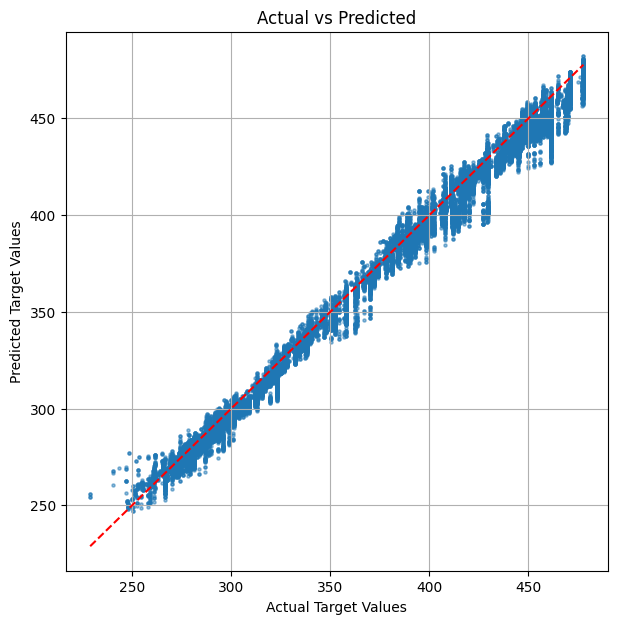

In [15]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, preds_mlp, s=5, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

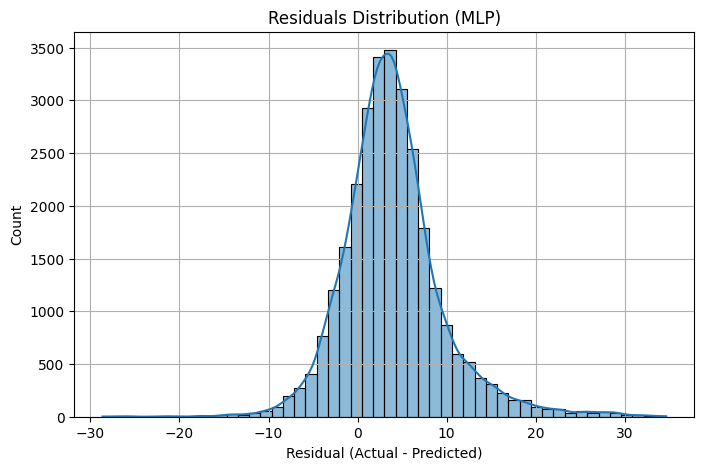

In [17]:
residuals = y_test - preds_mlp

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title("Residuals Distribution (MLP)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


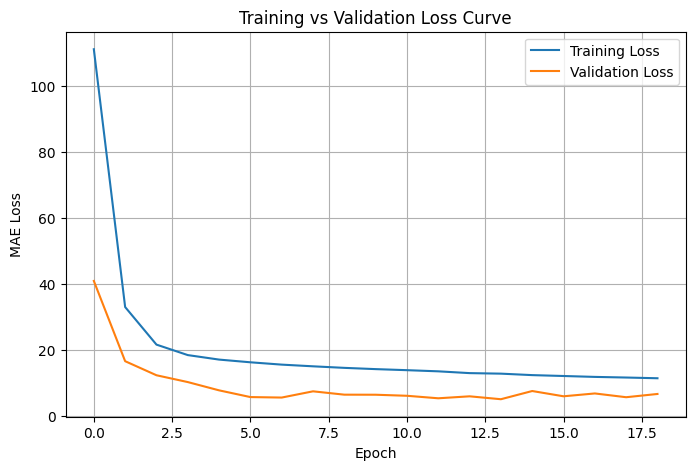

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model for Forward Max Price Prediction

## Objective
Use Long Short-Term Memory (LSTM) neural network to predict the forward maximum price using the same dataset as LightGBM.

---

## Steps

### Step 1: Train-Test Split
Randomly split the data into training (80%) and testing (20%) sets with a fixed random seed (42) for reproducibility.

### Step 2: Feature Standardization
Standardize features using StandardScaler — essential for neural networks to converge efficiently.

### Step 3: Data Cleaning
Handle any remaining NaN or infinite values by replacing them with zeros to ensure numerical stability.

### Step 4: Reshape for LSTM
Reshape input data to 3D format (samples, timesteps, features) required by LSTM layers. Using timesteps = 1 to treat each observation as a single-step sequence.

### Step 5: Model Architecture
Build an LSTM neural network with the following structure:
- LSTM layer: 64 units, return_sequences=False
- Dropout: 0.3
- Dense layer: 64 units, ReLU activation
- Dense layer: 32 units, ReLU activation
- Output layer: 1 unit (regression)

### Step 6: Model Training
Train the model with the following configuration:
- Optimizer: Adam
- Loss function: MAE
- Validation split: 20%
- Epochs: 20
- Batch size: 512

### Step 7: Evaluation
Evaluate model performance using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

In [21]:
def lstm_model(df, feature_cols, split_type='time', train_ratio=0.8, random_state=42, verbose=1):

    df = df.copy()
    X = df[feature_cols]
    y = df['target']
    
    # === Data Splitting ===
    if split_type == 'time':
        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_index = X_test.index
        
    elif split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_ratio, random_state=random_state
        )
        test_index = X_test.index
        
    else:
        raise ValueError("split_type must be 'time' or 'random'")
    
    # === Feature Scaling ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # === Handle NaN/Inf ===
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0, posinf=0, neginf=0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0, posinf=0, neginf=0)
    
    # === Reshape for LSTM: (samples, timesteps, features) ===
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    if verbose:
        print("LSTM input shape:", X_train_lstm.shape)
    
    # === RESET SEED RIGHT BEFORE MODEL CREATION ===
    set_seed(20)
    
    # === Model Architecture ===
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mae')
    
    if verbose:
        model.summary()
    
    # === Model Training ===
    history = model.fit(
        X_train_lstm,
        y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=512,
        verbose=verbose
    )
    
    # === Evaluation ===
    preds_lstm = model.predict(X_test_lstm).flatten()
    preds_lstm = np.nan_to_num(preds_lstm, nan=0, posinf=0, neginf=0)
    
    mae_lstm = mean_absolute_error(y_test, preds_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test, preds_lstm))
    
    print(f"\n[{split_type.upper()} Split] Test MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
    
    # === Store Predictions ===
    df['pred_LSTM'] = np.nan
    df.loc[test_index, 'pred_LSTM'] = preds_lstm
    
    return mae_lstm, rmse_lstm, df, history, preds_lstm, y_test

In [23]:
mae_lstm, rmse_lstm, df, history, preds_lstm, y_test = lstm_model(df, feature_cols, split_type='random', 
                                                                  train_ratio=0.8, random_state=42, verbose=1)

LSTM input shape: (116464, 1, 132)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                50432     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 56705 (221.50 KB)
Trainable params: 56705 (221.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________

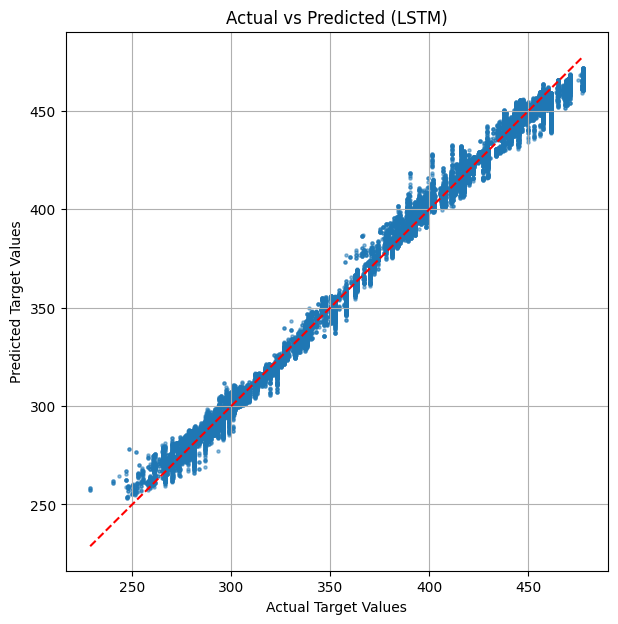

In [24]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, preds_lstm, s=5, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Actual vs Predicted (LSTM)")
plt.grid(True)
plt.show()


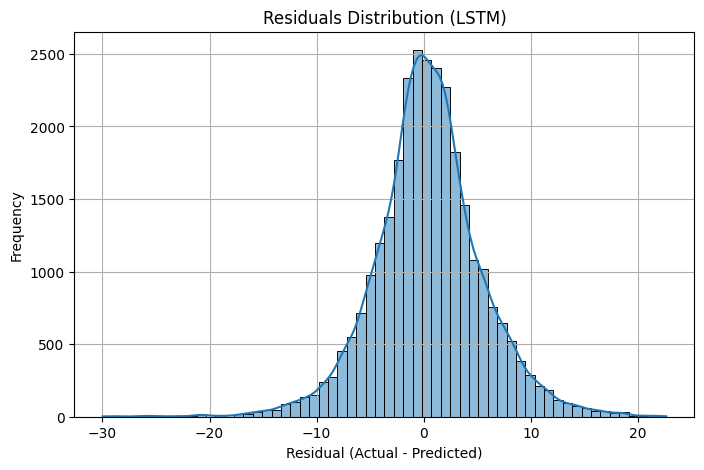

In [25]:
residuals = y_test - preds_lstm

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=60)
plt.title("Residuals Distribution (LSTM)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

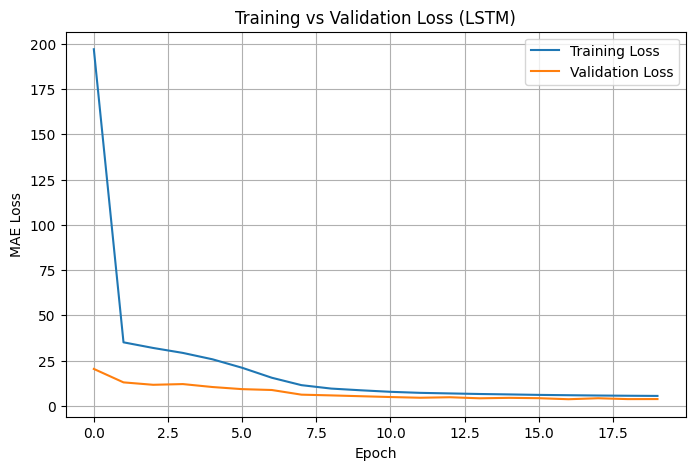

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training vs Validation Loss (LSTM)")
plt.legend()
plt.grid(True)
plt.show()


# SVR Model for Forward Max Price Prediction

## Objective

Use Support Vector Regression (SVR) to predict the forward maximum price.

---

## Steps

### Step 1: Use Same Train-Test Split

Use the same split training (80%) and testing (20%) datasets from LSTM and MLP.

### Step 2: Feature Standardization

Standardize both features (X) and target (y) using StandardScaler — required for SVR to perform well.

### Step 3: Model Training

Train SVR with RBF kernel using the following parameters:
- Kernel: RBF
- C: 1.0
- Epsilon: 0.1
- Gamma: scale
- Cache size: 2000 (for large dataset acceleration)

### Step 4: Batch Prediction

Predict on test set in batches (batch size = 1000) for efficiency, then inverse transform predictions back to original scale.

### Step 5: Evaluation

Evaluate model performance using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

In [31]:
def svr_model(df, feature_cols, split_type='time', train_ratio=0.8, random_state=42, verbose=True):

    df = df.copy()
    X = df[feature_cols]
    y = df['target']
    
    # === Data Splitting ===
    if split_type == 'time':
        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_index = X_test.index
        
    elif split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_ratio, random_state=random_state
        )
        test_index = X_test.index
        
    else:
        raise ValueError("split_type must be 'time' or 'random'")
    
    # === Feature Scaling (required for SVR) ===
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    
    # === Model Training ===
    model = SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.1,
        gamma='scale',
        shrinking=False,      # Faster
        cache_size=2000,      # Increased cache for large dataset
        verbose=verbose
    )
    
    model.fit(X_train_scaled, y_train_scaled)
    
    # === Batch Prediction with Progress Bar ===
    batch_size = 1000
    y_pred_list = []
    
    iterator = range(0, len(X_test_scaled), batch_size)
    if verbose:
        iterator = tqdm(iterator, desc="Predicting")
    
    for i in iterator:
        batch = X_test_scaled[i:i+batch_size]
        y_pred_list.extend(model.predict(batch))
    
    y_pred_scaled = np.array(y_pred_list)
    preds_svr = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    # === Evaluation ===
    mae_svr = mean_absolute_error(y_test, preds_svr)
    rmse_svr = np.sqrt(mean_squared_error(y_test, preds_svr))
    
    print(f"\n[{split_type.upper()} Split] SVR Test MAE: {mae_svr:.4f}, RMSE: {rmse_svr:.4f}")
    
    # === Store Predictions ===
    df['pred_SVR'] = np.nan
    df.loc[test_index, 'pred_SVR'] = preds_svr
    
    return mae_svr, rmse_svr, df, model, preds_svr, y_test

In [33]:
mae_svr, rmse_svr, df, model, preds_svr, y_test = svr_model(df, feature_cols, split_type='random', 
                                                            train_ratio=0.8, random_state=42, verbose=True)

[LibSVM]...................*
optimization finished, #iter = 19928
obj = -182.440670, rho = 0.628686
nSV = 5055, nBSV = 4390


Predicting: 100%|███████████████████████████████| 30/30 [00:14<00:00,  2.10it/s]


[RANDOM Split] SVR Test MAE: 3.1168, RMSE: 3.7726


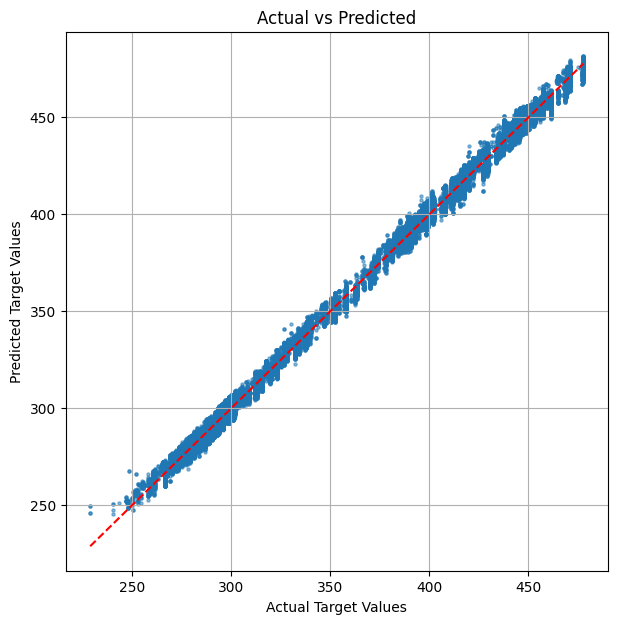

In [34]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, preds_svr, s=5, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

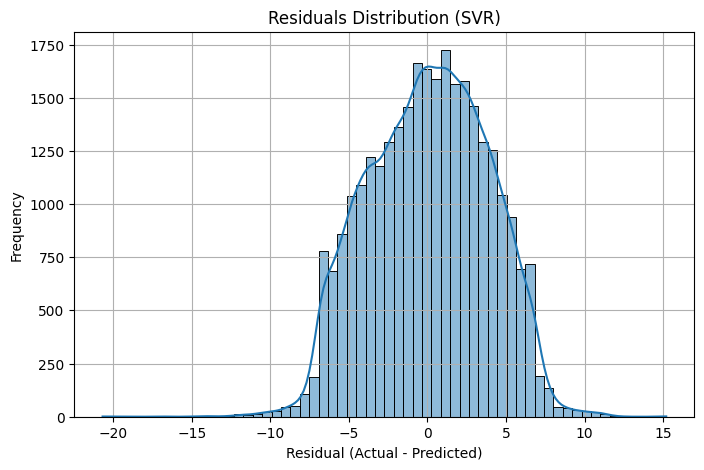

In [35]:
residuals = y_test - preds_svr

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=60)
plt.title("Residuals Distribution (SVR)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# LightGBM Model for Forward Max Price Prediction

## Objective

Use LightGBM to predict the forward maximum price based on days to expiration and historical price patterns.

---

## Steps

### Step 1: Construct Target Variable

Select the corresponding forward max price column based on `days_to_exp` (1-42 days).

### Step 2: Feature Engineering

**Base Features:**
- SPY Price
- Days to expiration
- Dividend Yield
- Risk-free rate
- Standard deviation (volatility)
- SD of SD

**Lookback Features (1-42 days):**
- Max - Back
- Min - Back
- Delta Back

### Step 3: Data Cleaning

- Remove rows with missing target values
- Convert all features to numeric
- Drop rows with missing feature values

### Step 4: Train-Test Split

Split data randomly: 80% training, 20% testing.

### Step 5: Model Training

Train LightGBM with the following parameters:
- Objective: Regression
- Metric: MAE
- Boosting type: GBDT
- Number of leaves: 31
- Learning rate: 0.05
- Feature fraction: 0.8

### Step 6: Evaluation

Evaluate model performance using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

In [47]:
def lgb_model(df, feature_cols, split_type='time', train_ratio=0.8, random_state=42, verbose=False):
    df = df.copy()
    X = df[feature_cols]
    y = df['target']
    
    # === Data Splitting ===
    if split_type == 'time':
        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_index = X_test.index
    elif split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_ratio, random_state=random_state
        )
        test_index = X_test.index
    else:
        raise ValueError("split_type must be 'time' or 'random'")
    
    # === Improved Parameters ===
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 63,
        'max_depth': 8,
        'learning_rate': 0.02,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'min_child_samples': 20,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': random_state
    }
    
    # === Training with Early Stopping ===
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_test, y_test, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=3000,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100 if verbose else 0)
        ]
    )
    
    # === Prediction & Evaluation ===
    preds_gbm = model.predict(X_test)
    mae_gbm = mean_absolute_error(y_test, preds_gbm)
    rmse_gbm = np.sqrt(mean_squared_error(y_test, preds_gbm))
    
    print(f"\n[{split_type.upper()} Split] LightGBM MAE: {mae_gbm:.4f}, RMSE: {rmse_gbm:.4f}")
    print(f"Best iteration: {model.best_iteration}")
    
    df['pred_GBM'] = np.nan
    df.loc[test_index, 'pred_GBM'] = preds_gbm
    
    return mae_gbm, rmse_gbm, df, model, preds_gbm, y_test

In [49]:
mae_gbm, rmse_gbm, df, model, preds_gbm, y_test = lgb_model(df, feature_cols, split_type='random', 
                                                            train_ratio=0.8, random_state=42, verbose=False)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[3000]	valid_0's l1: 0.502069

[RANDOM Split] LightGBM MAE: 0.5021, RMSE: 0.7610
Best iteration: 3000


In [41]:
def lgb_grid_search(df, feature_cols, split_type='time', train_ratio=0.8, random_state=42):
    df = df.copy()
    X = df[feature_cols]
    y = df['target']
    
    if split_type == 'time':
        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        test_index = X_test.index
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_ratio, random_state=random_state
        )
        test_index = X_test.index
    
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_test, y_test, reference=train_data)
    
    grid = {
        'num_leaves': [55, 70],
        'learning_rate': [0.015, 0.025],
        'feature_fraction': [0.65, 0.75],
        'lambda_l1': [0.05, 0.15],
    }    
    
    best_mae = float('inf')
    best_params = None
    
    keys = list(grid.keys())
    for values in product(*grid.values()):
        test_params = dict(zip(keys, values))
        
        params = {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'max_depth': 8,
            'lambda_l2': 0.1,
            'min_child_samples': 20,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'seed': random_state,
            **test_params
        }
        
        model = lgb.train(
            params, train_data, num_boost_round=2000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        mae = model.best_score['valid_0']['l1']
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            print(f"New best MAE: {mae:.4f} | {test_params}")
    
    # Final model
    model = lgb.train(
        best_params, train_data, num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    preds_gbm = model.predict(X_test)
    mae_gbm = mean_absolute_error(y_test, preds_gbm)
    rmse_gbm = np.sqrt(mean_squared_error(y_test, preds_gbm))
    
    print(f"\nFinal best params: {best_params}")
    print(f"MAE: {mae_gbm:.4f}, RMSE: {rmse_gbm:.4f}")
    
    df['pred_GBM'] = np.nan
    df.loc[test_index, 'pred_GBM'] = preds_gbm
    
    return mae_gbm, rmse_gbm, df, model, preds_gbm, y_test

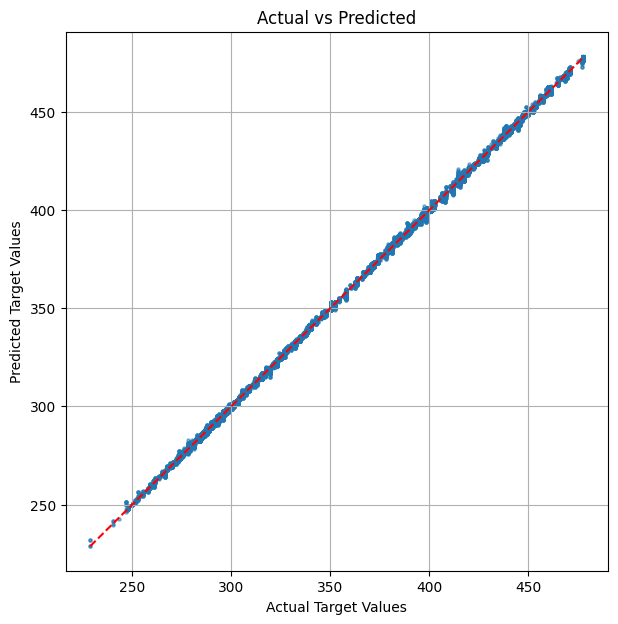

In [51]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, preds_gbm, s=5, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

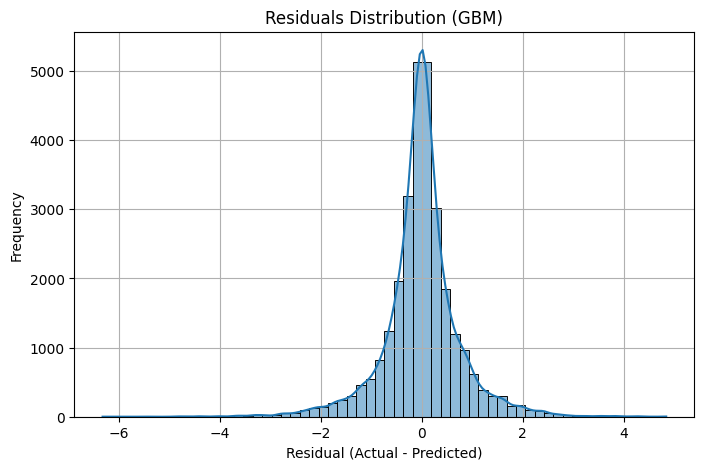

In [53]:
residuals = y_test - preds_gbm

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=60)
plt.title("Residuals Distribution (GBM)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Summary

In [55]:
print("The summary of results are:\n")

print(f"MLP Test MAE: {mae_mlp:.4f}")
print(f"MLP Test RMSE: {rmse_mlp:.4f}")
print()

print(f"LSTM Test MAE: {mae_lstm:.4f}")
print(f"LSTM Test RMSE: {rmse_lstm:.4f}")
print()

print(f"SVR Test MAE: {mae_svr:.4f}")
print(f"SVR Test RMSE: {rmse_svr:.4f}")
print()

print(f"LightGBM Test MAE: {mae_gbm:.4f}")
print(f"LightGBM Test RMSE: {rmse_gbm:.4f}")

The summary of results are:

MLP Test MAE: 5.1479
MLP Test RMSE: 6.9084

LSTM Test MAE: 3.7786
LSTM Test RMSE: 5.0878

SVR Test MAE: 3.1168
SVR Test RMSE: 3.7726

LightGBM Test MAE: 0.5021
LightGBM Test RMSE: 0.7610


In [57]:
print("\n" + "=" * 40)
print(f"{'Model':<12} {'MAE':>12} {'RMSE':>12}")
print("=" * 40)
print(f"{'MLP':<12} {mae_mlp:>12.4f} {rmse_mlp:>12.4f}")
print(f"{'LSTM':<12} {mae_lstm:>12.4f} {rmse_lstm:>12.4f}")
print(f"{'SVR':<12} {mae_svr:>12.4f} {rmse_svr:>12.4f}")
print(f"{'GBM':<12} {mae_gbm:>12.4f} {rmse_gbm:>12.4f}")
print("=" * 40)


Model                 MAE         RMSE
MLP                5.1479       6.9084
LSTM               3.7786       5.0878
SVR                3.1168       3.7726
GBM                0.5021       0.7610


In [59]:
def calculate_payoff(df):
    for model in ['MLP', 'LSTM', 'SVR', 'GBM']:
        df[f'{model} predicted max vs strike'] = df[f'pred_{model}'] - df['strike_price_adj']
    return df

df = calculate_payoff(df)

In [63]:
pd.set_option('display.max_columns', None)
df.head()

,SPY Price,best_bid,best_offer,cp_flag,date,days_to_exp,delta,exdate,expiry_indicator,gamma,impl_volatility,last_date,moneyness,open_interest,optionid,symbol,theta,vega,volume,strike_price,option_price_mid,Dates,IsTradingDay,Trading Index,Dates_parsed,SPDR S&P 500 ETF (ARCA:SPY) - Share Pricing,SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield,Log Returns,Standard deviation (annual),SD of SD,Risk-free rate (annual),Lookback for Calculating Volatility,Max - Forward 1,Max - Forward 2,Max - Forward 3,Max - Forward 4,Max - Forward 5,Max - Forward 6,Max - Forward 7,Max - Forward 8,Max - Forward 9,Max - Forward 10,Max - Forward 11,Max - Forward 12,Max - Forward 13,Max - Forward 14,Max - Forward 15,Max - Forward 16,Max - Forward 17,Max - Forward 18,Max - Forward 19,Max - Forward 20,Max - Forward 21,Max - Forward 22,Max - Forward 23,Max - Forward 24,Max - Forward 25,Max - Forward 26,Max - Forward 27,Max - Forward 28,Max - Forward 29,Max - Forward 30,Max - Forward 31,Max - Forward 32,Max - Forward 33,Max - Forward 34,Max - Forward 35,Max - Forward 36,Max - Forward 37,Max - Forward 38,Max - Forward 39,Max - Forward 40,Max - Forward 41,Max - Forward 42,Prediction 42,Loss,Max - Back 1,Min - Back 1,Delta Back 1,Max - Back 2,Min - Back 2,Delta Back 2,Max - Back 3,Min - Back 3,Delta Back 3,Max - Back 4,Min - Back 4,Delta Back 4,Max - Back 5,Min - Back 5,Delta Back 5,Max - Back 6,Min - Back 6,Delta Back 6,Max - Back 7,Min - Back 7,Delta Back 7,Max - Back 8,Min - Back 8,Delta Back 8,Max - Back 9,Min - Back 9,Delta Back 9,Max - Back 10,Min - Back 10,Delta Back 10,Max - Back 11,Min - Back 11,Delta Back 11,Max - Back 12,Min - Back 12,Delta Back 12,Max - Back 13,Min - Back 13,Delta Back 13,Max - Back 14,Min - Back 14,Delta Back 14,Max - Back 15,Min - Back 15,Delta Back 15,Max - Back 16,Min - Back 16,Delta Back 16,Max - Back 17,Min - Back 17,Delta Back 17,Max - Back 18,Min - Back 18,Delta Back 18,Max - Back 19,Min - Back 19,Delta Back 19,Max - Back 20,Min - Back 20,Delta Back 20,Max - Back 21,Min - Back 21,Delta Back 21,Max - Back 22,Min - Back 22,Delta Back 22,Max - Back 23,Min - Back 23,Delta Back 23,Max - Back 24,Min - Back 24,Delta Back 24,Max - Back 25,Min - Back 25,Delta Back 25,Max - Back 26,Min - Back 26,Delta Back 26,Max - Back 27,Min - Back 27,Delta Back 27,Max - Back 28,Min - Back 28,Delta Back 28,Max - Back 29,Min - Back 29,Delta Back 29,Max - Back 30,Min - Back 30,Delta Back 30,Max - Back 31,Min - Back 31,Delta Back 31,Max - Back 32,Min - Back 32,Delta Back 32,Max - Back 33,Min - Back 33,Delta Back 33,Max - Back 34,Min - Back 34,Delta Back 34,Max - Back 35,Min - Back 35,Delta Back 35,Max - Back 36,Min - Back 36,Delta Back 36,Max - Back 37,Min - Back 37,Delta Back 37,Max - Back 38,Min - Back 38,Delta Back 38,Max - Back 39,Min - Back 39,Delta Back 39,Max - Back 40,Min - Back 40,Delta Back 40,Max - Back 41,Min - Back 41,Delta Back 41,Max - Back 42,Min - Back 42,Delta Back 42,Dates_clean,target,Dividend Yield Clean,Dividend_Yield_Clean,strike_price_adj,T,d1,d2,N_d1,N_d2,BS_call,pred_MLP,pred_LSTM,pred_SVR,pred_GBM,MLP predicted max vs strike,LSTM predicted max vs strike,SVR predicted max vs strike,GBM predicted max vs strike
0,272.14999,2.63,2.70,C,2018-05-25,31,0.494289,2018-06-25,w,0.058981,0.092936,2018-05-25,0.998716,251,120650190,SPY 180625C272500,-21.19609,30.53122,45,272500,2.665,May-25-2018,True,648.0,2018-05-25,272.15,1.76%,-0.002386,0.143148,0.028159,0.0186,NaN,272.15,272.15,272.15,272.15,272.61,272.61,273.6,273.6,273.6,274.9,275.1,277.4,277.4,278.19,278.19,278.19,278.56,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,278.92,283.290098,19.097755,272.8,272.15,1.002388,273.36,272.15,1.004446,273.36,272.15,1.004446,273.37,272.15,1.004483,273.37,271.33,1.007519,273.37,271.33,1.007519,273.37,271.33,1.007519,273.37,271.33,1.007519,273.37,271.33,1.007519,273.37,271.1,1.008373,273.37,271.1,1.008373,273.37,271.1,1.008373,273.

# Problem

Random splitting may cause data leakage: since multiple observations share the same date, the model could have already seen similar patterns during training, leading to overly optimistic results.

# Solution: Time-Based Train/Test Split
Earlier 80% for training, later 20% for testing — no future information leaks into training.

In [69]:
df = data_all.dropna(subset=['target']).copy()
print(f"After dropping null targets: {len(df)} rows")

for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nMissing values per feature:")
for col in feature_cols:
    missing = df[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing")

df = df.dropna(subset=feature_cols)
print(f"\nAfter dropping missing features: {len(df)} rows")

X = df[feature_cols]
y = df['target']

# Sort by date for time-series split
df = df.sort_values('date').reset_index(drop=True)

After dropping null targets: 145580 rows

Missing values per feature:

After dropping missing features: 145580 rows


## Re-run Four Models: MLP, LSTM, SVR, LightGBM (with grid search)

In [70]:
# MLP
mae_mlp_time, rmse_mlp_time, df, history, preds_mlp, y_test = mlp_model(df, feature_cols, split_type='time', 
                                                                        train_ratio=0.8, random_state=42, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               34048     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 132865 (519.00 KB)
Trainable params: 132

In [73]:
# LSTM
mae_lstm_time, rmse_lstm_time, df, history, preds_lstm, y_test = lstm_model(df, feature_cols, split_type='time', 
                                                                            train_ratio=0.8, random_state=42, verbose=1)

LSTM input shape: (116464, 1, 132)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                50432     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 56705 (221.50 KB)
Trainable params: 56705 (221.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________

In [75]:
# SVR
mae_svr_time, rmse_svr_time, df, model, preds_svr, y_test = svr_model(df, feature_cols, split_type='time', 
                                                                      train_ratio=0.8, random_state=42, verbose=True)

[LibSVM]...........*
optimization finished, #iter = 11833
obj = -69.561726, rho = 0.626883
nSV = 2505, nBSV = 2059


Predicting: 100%|███████████████████████████████| 30/30 [00:07<00:00,  4.17it/s]


[TIME Split] SVR Test MAE: 19.5438, RMSE: 24.7248


In [79]:
# LightGBM with Grid Search
mae_gbm_time, rmse_gbm_time, df, model, preds_gbm, y_test = lgb_grid_search(df, feature_cols, split_type='time', 
                                                                            train_ratio=0.8, random_state=42)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[415]	valid_0's l1: 10.7926
New best MAE: 10.7926 | {'num_leaves': 55, 'learning_rate': 0.015, 'feature_fraction': 0.65, 'lambda_l1': 0.05}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[485]	valid_0's l1: 10.7866
New best MAE: 10.7866 | {'num_leaves': 55, 'learning_rate': 0.015, 'feature_fraction': 0.65, 'lambda_l1': 0.15}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[517]	valid_0's l1: 11.0258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[514]	valid_0's l1: 11.0771
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's l1: 10.955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid_0's l1: 10.9143
Training until validation scores 

In [107]:
print("The summary of updated results are:\n")

print(f"MLP Test MAE: {mae_mlp_time:.4f}")
print(f"MLP Test RMSE: {rmse_mlp_time:.4f}")
print()

print(f"LSTM Test MAE: {mae_lstm_time:.4f}")
print(f"LSTM Test RMSE: {rmse_lstm_time:.4f}")
print()

print(f"SVR Test MAE: {mae_svr_time:.4f}")
print(f"SVR Test RMSE: {rmse_svr_time:.4f}")
print()

print(f"LightGBM Test MAE: {mae_gbm_time:.4f}")
print(f"LightGBM Test RMSE: {rmse_gbm_time:.4f}")

The summary of updated results are:

MLP Test MAE: 23.1968
MLP Test RMSE: 27.9153

LSTM Test MAE: 22.4989
LSTM Test RMSE: 26.9969

SVR Test MAE: 19.5438
SVR Test RMSE: 24.7248

LightGBM Test MAE: 10.7407
LightGBM Test RMSE: 13.6860


In [109]:
print("\n" + "=" * 40)
print(f"{'Model':<12} {'MAE':>12} {'RMSE':>12}")
print("=" * 40)
print(f"{'MLP':<12} {mae_mlp_time:>12.4f} {rmse_mlp_time:>12.4f}")
print(f"{'LSTM':<12} {mae_lstm_time:>12.4f} {rmse_lstm_time:>12.4f}")
print(f"{'SVR':<12} {mae_svr_time:>12.4f} {rmse_svr_time:>12.4f}")
print(f"{'GBM':<12} {mae_gbm_time:>12.4f} {rmse_gbm_time:>12.4f}")
print("=" * 40)


Model                 MAE         RMSE
MLP               23.1968      27.9153
LSTM              22.4989      26.9969
SVR               19.5438      24.7248
GBM               10.7407      13.6860


In [86]:
def calculate_payoff(df):
    for model in ['MLP', 'LSTM', 'SVR', 'GBM']:
        df[f'{model} predicted max vs strike'] = df[f'pred_{model}'] - df['strike_price_adj']
    return df

df = calculate_payoff(df)

In [111]:
pd.set_option('display.max_columns', None)
df.tail()

,SPY Price,best_bid,best_offer,cp_flag,date,days_to_exp,delta,exdate,expiry_indicator,gamma,impl_volatility,last_date,moneyness,open_interest,optionid,symbol,theta,vega,volume,strike_price,option_price_mid,Dates,IsTradingDay,Trading Index,Dates_parsed,SPDR S&P 500 ETF (ARCA:SPY) - Share Pricing,SPDR S&P 500 ETF (ARCA:SPY) - Dividend Yield,Log Returns,Standard deviation (annual),SD of SD,Risk-free rate (annual),Lookback for Calculating Volatility,Max - Forward 1,Max - Forward 2,Max - Forward 3,Max - Forward 4,Max - Forward 5,Max - Forward 6,Max - Forward 7,Max - Forward 8,Max - Forward 9,Max - Forward 10,Max - Forward 11,Max - Forward 12,Max - Forward 13,Max - Forward 14,Max - Forward 15,Max - Forward 16,Max - Forward 17,Max - Forward 18,Max - Forward 19,Max - Forward 20,Max - Forward 21,Max - Forward 22,Max - Forward 23,Max - Forward 24,Max - Forward 25,Max - Forward 26,Max - Forward 27,Max - Forward 28,Max - Forward 29,Max - Forward 30,Max - Forward 31,Max - Forward 32,Max - Forward 33,Max - Forward 34,Max - Forward 35,Max - Forward 36,Max - Forward 37,Max - Forward 38,Max - Forward 39,Max - Forward 40,Max - Forward 41,Max - Forward 42,Prediction 42,Loss,Max - Back 1,Min - Back 1,Delta Back 1,Max - Back 2,Min - Back 2,Delta Back 2,Max - Back 3,Min - Back 3,Delta Back 3,Max - Back 4,Min - Back 4,Delta Back 4,Max - Back 5,Min - Back 5,Delta Back 5,Max - Back 6,Min - Back 6,Delta Back 6,Max - Back 7,Min - Back 7,Delta Back 7,Max - Back 8,Min - Back 8,Delta Back 8,Max - Back 9,Min - Back 9,Delta Back 9,Max - Back 10,Min - Back 10,Delta Back 10,Max - Back 11,Min - Back 11,Delta Back 11,Max - Back 12,Min - Back 12,Delta Back 12,Max - Back 13,Min - Back 13,Delta Back 13,Max - Back 14,Min - Back 14,Delta Back 14,Max - Back 15,Min - Back 15,Delta Back 15,Max - Back 16,Min - Back 16,Delta Back 16,Max - Back 17,Min - Back 17,Delta Back 17,Max - Back 18,Min - Back 18,Delta Back 18,Max - Back 19,Min - Back 19,Delta Back 19,Max - Back 20,Min - Back 20,Delta Back 20,Max - Back 21,Min - Back 21,Delta Back 21,Max - Back 22,Min - Back 22,Delta Back 22,Max - Back 23,Min - Back 23,Delta Back 23,Max - Back 24,Min - Back 24,Delta Back 24,Max - Back 25,Min - Back 25,Delta Back 25,Max - Back 26,Min - Back 26,Delta Back 26,Max - Back 27,Min - Back 27,Delta Back 27,Max - Back 28,Min - Back 28,Delta Back 28,Max - Back 29,Min - Back 29,Delta Back 29,Max - Back 30,Min - Back 30,Delta Back 30,Max - Back 31,Min - Back 31,Delta Back 31,Max - Back 32,Min - Back 32,Delta Back 32,Max - Back 33,Min - Back 33,Delta Back 33,Max - Back 34,Min - Back 34,Delta Back 34,Max - Back 35,Min - Back 35,Delta Back 35,Max - Back 36,Min - Back 36,Delta Back 36,Max - Back 37,Min - Back 37,Delta Back 37,Max - Back 38,Min - Back 38,Delta Back 38,Max - Back 39,Min - Back 39,Delta Back 39,Max - Back 40,Min - Back 40,Delta Back 40,Max - Back 41,Min - Back 41,Delta Back 41,Max - Back 42,Min - Back 42,Delta Back 42,Dates_clean,target,Dividend Yield Clean,Dividend_Yield_Clean,strike_price_adj,T,d1,d2,N_d1,N_d2,BS_call,pred_MLP,pred_LSTM,pred_SVR,pred_GBM,MLP predicted max vs strike,LSTM predicted max vs strike,SVR predicted max vs strike,GBM predicted max vs strike
145575,380.82001,5.99,6.01,C,2023-01-03,6,0.617623,2023-01-09,w,0.035303,0.221257,2023-01-03,1.007460,891,151714097,SPY 230109C378000,-134.4925,18.626780,2549,378000,6.000,Jan-03-2023,True,2332.0,2023-01-03,380.82,1.62%,-0.004219,0.260931,0.022809,0.044,NaN,383.76,383.76,388.08,388.08,388.08,388.08,390.58,395.52,396.96,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,398.5,400.63,400.63,400.63,404.75,405.68,405.68,405.68,405.68,406.48,410.8,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,416.78,412.182599,21.136099,382.43,380.82,1.004228,382.43,380.82,1.004228,382.43,380.82,1.004228,382.43,380.82,1.004228,383.44,380.82,1.00688,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,383.44,376.66,1.018,386.23,376.66,1.025

In [113]:
summary_full = pd.DataFrame()
for model in ['MLP', 'LSTM', 'SVR', 'GBM']:
    col = f'{model} predicted max vs strike'
    summary_full[model] = [
        df[col].count(),
        df[col].mean(),
        df[col].std(),
        df[col].min(),
        df[col].quantile(0.25),
        df[col].quantile(0.50),
        df[col].quantile(0.75),
        df[col].max(),
        (df[col] > 0).mean(),
        (df[col] - df['BS_call']).mean(),
        df[col].corr(df['BS_call'])
    ]

summary_full['BS_call'] = [
    df['BS_call'].count(),
    df['BS_call'].mean(),
    df['BS_call'].std(),
    df['BS_call'].min(),
    df['BS_call'].quantile(0.25),
    df['BS_call'].quantile(0.50),
    df['BS_call'].quantile(0.75),
    df['BS_call'].max(),
    (df['BS_call'] > 0).mean(),
    0,  # BS vs BS = 0
    1   # Corr with itself = 1
]

summary_full.index = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 
                      'Win Rate', 'Mean Diff vs BS', 'Corr with BS']
summary_full.round(4)

,MLP,LSTM,SVR,GBM,BS_call
Count,29116.0000,29116.0000,29116.0000,29116.0000,145568.0000
Mean,-11.0267,11.9865,-1.5032,5.5434,5.4875
Std,14.9374,28.8947,21.9160,10.2735,3.3114
Min,-47.0002,-57.8783,-55.2653,-22.0517,0.0000
25%,-24.6152,-9.8643,-18.0943,-2.0692,3.1890
50%,-10.3311,15.9546,0.1962,5.0405,4.9329
75%,1.6365,33.5622,14.8520,12.5400,7.1686
Max,25.1332,75.0132,57.7500,37.0639,18.8781
Win Rate,0.0576,0.1333,0.1006,0.1368,0.9778
Mean Diff vs BS,-18.2149,4.7992,-8.6915,-1.6440,0.0000


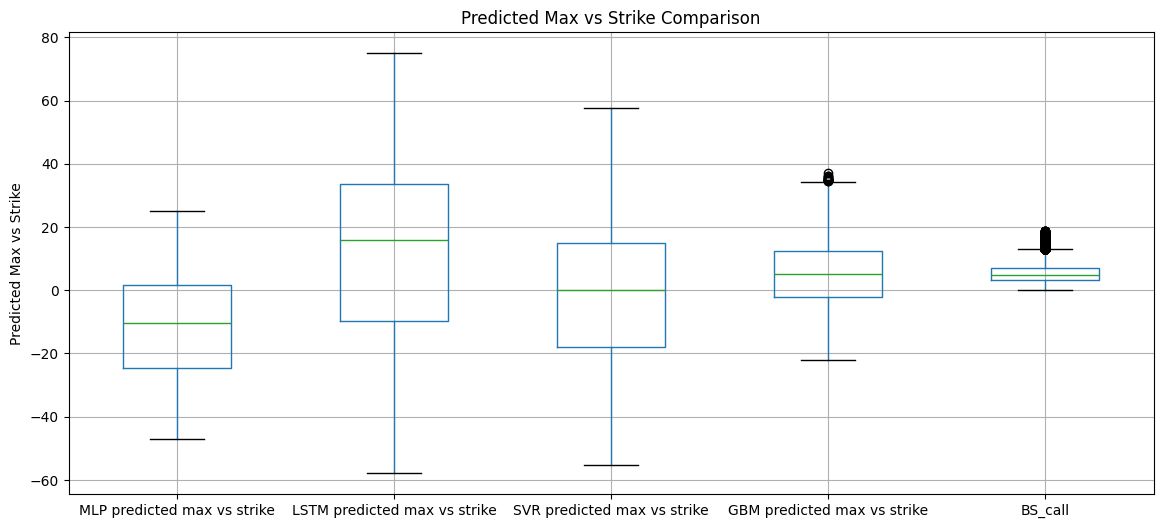

In [115]:
# boxplot
cols = ['MLP predicted max vs strike', 
        'LSTM predicted max vs strike', 
        'SVR predicted max vs strike', 
        'GBM predicted max vs strike',
        'BS_call']

df[cols].boxplot(figsize=(14, 6))
plt.title('Predicted Max vs Strike Comparison')
plt.ylabel('Predicted Max vs Strike')
plt.show()

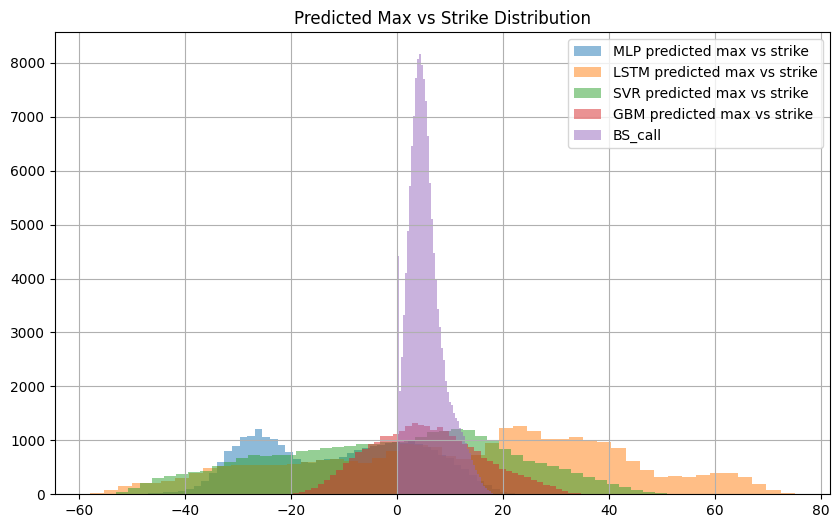

In [117]:
# Distribution
fig, ax = plt.subplots(figsize=(10, 6))
for col in cols:
    df[col].hist(alpha=0.5, label=col, bins=50)
plt.legend()
plt.title('Predicted Max vs Strike Distribution')
plt.show()

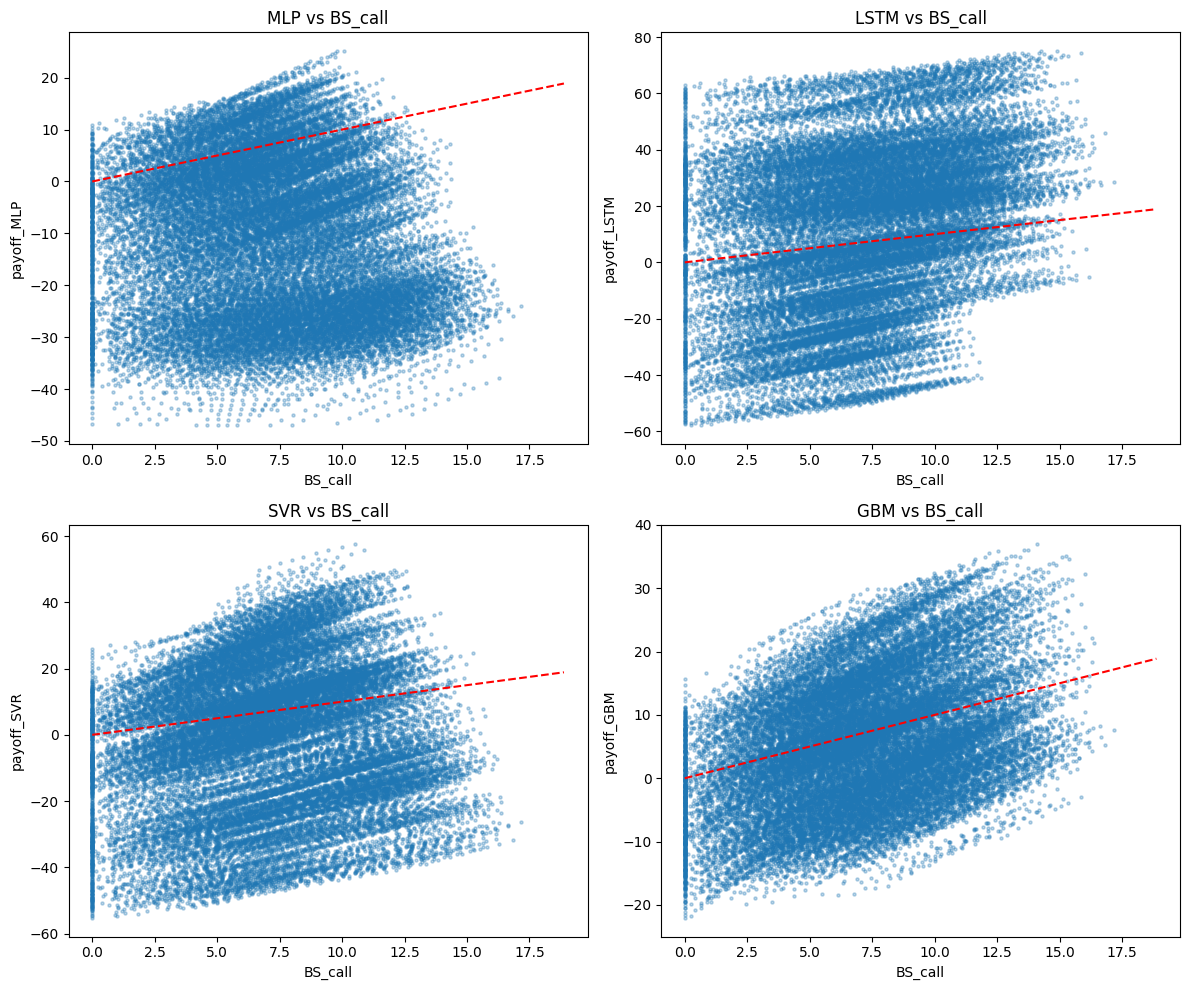

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, model in zip(axes.flatten(), ['MLP', 'LSTM', 'SVR', 'GBM']):
    ax.scatter(df['BS_call'], df[f'{model} predicted max vs strike'], alpha=0.3, s=5)
    ax.plot([df['BS_call'].min(), df['BS_call'].max()], 
            [df['BS_call'].min(), df['BS_call'].max()], 'r--')
    ax.set_xlabel('BS_call')
    ax.set_ylabel(f'payoff_{model}')
    ax.set_title(f'{model} vs BS_call')
plt.tight_layout()
plt.show()

In [98]:
df.to_csv(
    "/Users/vera/Desktop/Algorithmic ML/project/data_payoff_split.csv",
    index=False
)

# Group Members and Contributions
- **Michael Brick**: Project conception, data acquisition from OptionMetrics and S&P Capital IQ, volatility metrics computation
- **Meng Li**:  Data cleaning and filtering, GBM and SVR implementation and evaluation, grid search, Black-Scholes comparison
- **Sharath Mohan Kumar**: MLP and LSTM neural network implementation and evaluation, graphic projections python coding